In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import roc_auc_score, log_loss, make_scorer, brier_score_loss
from sklearn.calibration import calibration_curve,CalibratedClassifierCV
# from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import xgboost as xgb
import metrics
from lipo import LIPOSearchCV

In [2]:
#mcfadden_r2 better fit for value- 0.2 to 0.4
def mcfadden_r2(y, y_pred):
    ll = log_loss(y, y_pred)
    ll_null = log_loss(y, np.full(len(y), y.mean()))
    return 1 - (ll/ll_null)
pseudo_r2_scorer = make_scorer(mcfadden_r2, needs_proba=True, greater_is_better=True)

In [13]:
df=pd.read_pickle('E:/Athan/football data/xG_Model/ShotData/setPieceshotsBig5_17-22.pkl')
df

,x,y,isGoal,isBigChance,isCounter,isFoot,dist,angle_rad,assistType,isPrevShot,playType
0,31.290,29.716,0,0,0,1,31.581906,0.228690,2,0,2
1,29.505,33.796,0,0,0,1,29.505705,0.246821,0,0,2
2,8.400,35.768,0,0,0,0,8.584045,0.795234,2,0,3
3,18.480,35.700,0,0,0,1,18.558028,0.387963,2,0,2
4,7.665,37.604,0,0,0,0,8.470008,0.765850,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...
71626,22.155,24.004,0,0,0,0,24.305638,0.273830,2,0,2
71627,4.410,32.912,0,1,0,0,4.542229,1.350279,0,0,2
71628,3.255,32.232,0,0,0,0,3.704166,1.557147,2,0,2
71629,4.410,35.224,0,1,0,0,4.576710,1.341024,0,0,2


In [14]:
playType={0:'OpenPlay',1:'ThrowinSetPiece',2:'FromCorner',3:'SetPiece',4:'DirectFreekick',5:'Penalty',6:'None'}
df['playTypeName']=df['playType'].map(playType)
df['playTypeName'].value_counts()

FromCorner         40686
SetPiece           17472
DirectFreekick     11464
ThrowinSetPiece     2009
Name: playTypeName, dtype: int64

In [15]:
#Filetring out direct freekick shot attempts as training features are different for them
df=df[df['playType']!=4].reset_index(drop=True)

In [16]:
#Categorical data
df['playType']=df['playType'].replace(1,0)
df['playType']=df['playType'].replace(2,1)
df['playType']=df['playType'].replace(3,2)
df['playType'].value_counts()

1    40686
2    17472
0     2009
Name: playType, dtype: int64

In [17]:
#Features to be used for xgboost model
train_df=df[['x','y','isBigChance','isFoot','dist',
            'angle_rad','assistType','isPrevShot','playType']]
features=np.array(train_df)
goal=np.array(df['isGoal'])
features.shape,goal.shape

((60167, 9), (60167,))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train_df, df['isGoal'], train_size=0.8, random_state=42, stratify=goal)

In [19]:
print('Shots train', len(y_train), ';Number goals', y_train.sum(),
      ';Goals %: ', round(y_train.mean()*100, 2))
print('Shots test', len(y_test), ';Number goals', y_test.sum(),
      ';Goals %: ', round(y_test.mean()*100, 2))

Shots train 48133 ;Number goals 3504 ;Goals %:  7.28
Shots test 12034 ;Number goals 876 ;Goals %:  7.28


## Hyperparameter Tuning and training the model

> Added a monotone constraint to capture the real life relationship between angle to the goal and goal scored.

> Using brier scoring to optimize for probablity calibration

In [20]:
if __name__ == '__main__':
    fix_params = {'objective': 'binary:logistic','eval_metric':'logloss',
                  'max_delta_step':1,'tree_method':'hist',
                  'monotone_constraints':{'angle_rad':1},
                  'random_state':42}

#     fix_params.update(grid_search.best_params_) #Update the parameters dict with the tuned learning rates & n_estimators
    model=xgb.XGBClassifier(**fix_params)

    xgb_param_grid ={
            'min_child_weight': [0, 5],
            'max_depth': [5, 40],
            'subsample': [0.01, 1.0],
            'colsample_bytree': [0.01, 1.0],
            'colsample_bylevel': [0.01, 1.0],
            'reg_lambda': [1e-9, 1000.0],
            'reg_alpha': [1e-9, 1.0],
            'scale_pos_weight':[0.1,200.0],
            'gamma': [1e-9, 0.5]
    }   
    # Hyperparameter tuning using LIPO. See: https://github.com/jdb78/lipo
    searchcv = LIPOSearchCV(estimator=model,
                             n_iter=100,
                            scoring='neg_brier_score',
                            param_space=xgb_param_grid,
                             cv=5,random_state=42,
                             n_jobs=-1,verbose=0,pre_dispatch=7)
    searchcv.fit(X_train, y_train)

Best params with score -0.054 at iteration 95: 100%|█████████████████████████████████| 100/100 [13:43<00:00,  8.24s/it]


In [21]:
searchcv.best_params_

{'min_child_weight': 5,
 'max_depth': 18,
 'subsample': 0.9999716598668882,
 'colsample_bytree': 0.5502931421258257,
 'colsample_bylevel': 0.7397314350948819,
 'reg_lambda': 879.4277286762252,
 'reg_alpha': 1.4627749318519372e-09,
 'scale_pos_weight': 1.081380650323279,
 'gamma': 3.160966246407243e-09}

## Tune Leanring Rate and Number of Estimators

In [42]:
if __name__ == '__main__':
    fix_params = {'objective': 'binary:logistic','eval_metric':'logloss','monotone_constraints':{'angle_rad':1},
                    'max_delta_step':1,'tree_method':'hist',
    #                   'grow_policy':'lossguide',#'gamma':0.4,'subsample':0.55, 
                     'random_state':42}
    fix_params.update(searchcv.best_params_) #Update the parameters dict with the tuned learning rates & n_estimators
    model=xgb.XGBClassifier(**fix_params)
    parm={'n_estimators':[200,300,400,500,600],
    'learning_rate': [0.01,0.02,0.1,0.2,0.3,0.4,0.5]}
    grid_search = GridSearchCV(model, parm, scoring='neg_brier_score', n_jobs=-1, cv=5, verbose=3)
    grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


Best: -0.054207 using {'learning_rate': 0.2, 'n_estimators': 300}


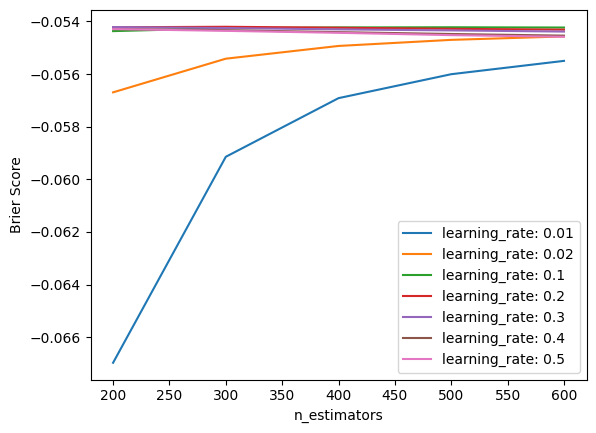

In [70]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
# 	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = np.array(means).reshape(len(parm['learning_rate']), len(parm['n_estimators']))
for i, value in enumerate(parm['learning_rate']):
    plt.plot(parm['n_estimators'], scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Brier Score')
plt.show()

In [44]:
grid_search.best_params_

{'learning_rate': 0.2, 'n_estimators': 300}

In [45]:
xgclass=grid_search.best_estimator_
xgclass

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.7397314350948819, colsample_bynode=1,
              colsample_bytree=0.5502931421258257, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=3.160966246407243e-09, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=1,
              max_depth=18, max_leaves=0, min_child_weight=5, missing=nan,
              monotone_constraints={'angle_rad': 1}, n_estimators=300, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

### Feature Importance

In [46]:
if __name__ == '__main__':
    perm_result = permutation_importance(xgclass, X_train, y_train, n_repeats=10, random_state=42,n_jobs=-1)
    df_perm_importance = pd.DataFrame({'Feature':train_df.columns,
                                       'importance': perm_result.importances.mean(axis=1),
                                       'std_dev': perm_result.importances.std(axis=1)})
    df_perm_importance.sort_values('importance', ascending=False, inplace=True)
    df_perm_importance.reset_index(drop=True, inplace=True)
df_perm_importance

,Feature,importance,std_dev
0,isBigChance,0.005682,0.000210
1,angle_rad,0.004469,0.000153
2,isFoot,0.002073,0.000280
3,dist,0.001569,0.000267
4,x,0.000819,0.000327
5,y,0.000744,0.000155
6,assistType,0.000536,0.000222
7,playType,0.000280,0.000135
8,isPrevShot,0.000158,0.000048


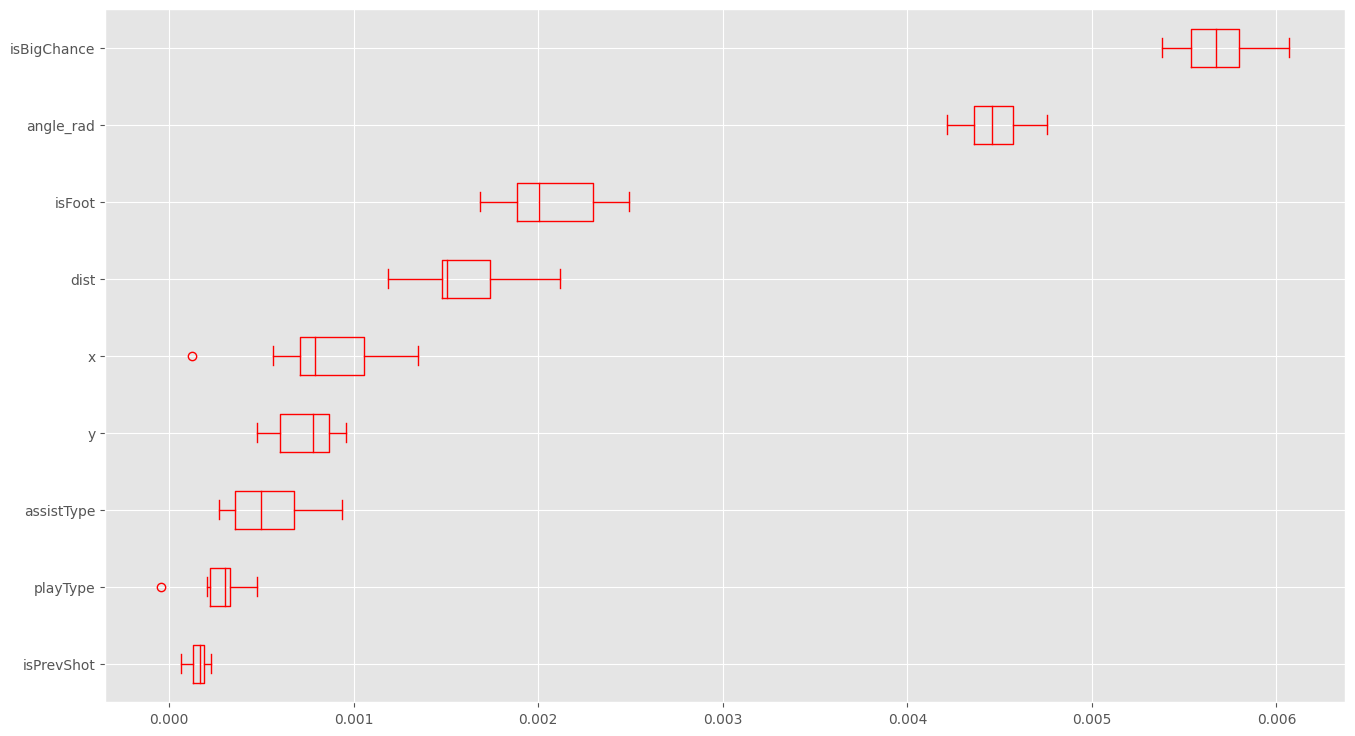

In [47]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result.importances_mean.argsort()
c='r'
bar_plot = ax.boxplot(perm_result.importances[sorted_idx].T, vert=False, labels=train_df.columns[sorted_idx]
                     ,boxprops=dict(color=c),capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))
# plt.show()

## Testing Data

In [48]:
y_pred=xgclass.predict(X_test)

In [49]:
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report,confusion_matrix
print("Test Accuracy: ",accuracy_score(y_test,y_pred )*100)
print("Train Accuracy: ",accuracy_score(y_train, (xgclass.predict(X_train)))*100)

Test Accuracy:  93.01146750872527
Train Accuracy:  93.31435813267404


In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     11158
           1       0.56      0.18      0.28       876

    accuracy                           0.93     12034
   macro avg       0.75      0.59      0.62     12034
weighted avg       0.91      0.93      0.91     12034



In [51]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
sensitivity= tp/(tp+fn)
print("sensitivity is: ",sensitivity)
print("specificity is: ",specificity)

sensitivity is:  0.18493150684931506
specificity is:  0.9886180319053594


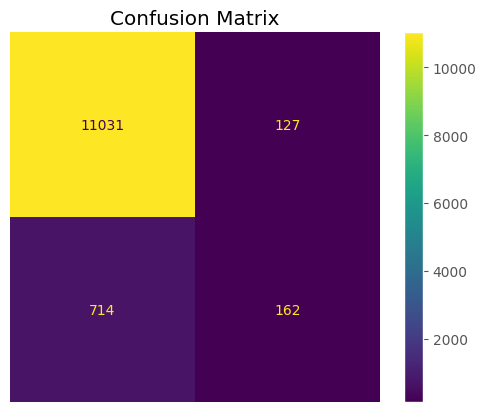

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay,log_loss,mean_squared_log_error

ConfusionMatrixDisplay.from_estimator(xgclass,X_test,y_test,cmap=plt.cm.viridis)
plt.title('Confusion Matrix')
plt.axis('off')
plt.show()

### Predict probablities on test data

In [53]:
y_pred_lgbm_calibrated = xgclass.predict_proba(X_test)[:, 1]

### Plot ROC Curve

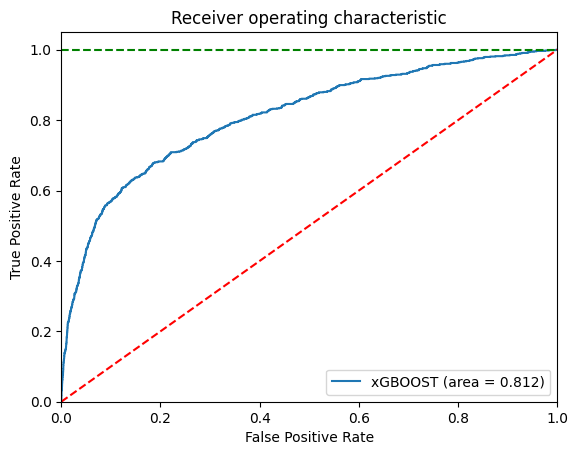

In [54]:
from sklearn.metrics import roc_curve,precision_score,recall_score,f1_score,roc_auc_score
logit_roc_auc = roc_auc_score(y_test,y_pred_lgbm_calibrated)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lgbm_calibrated)
plt.style.use('default')
plt.figure()
plt.plot(fpr, tpr, label='xGBOOST (area = %0.3f)' % logit_roc_auc)
plt.plot([0, 1], [1, 1],'g--')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

### Plot Calibration Curve and distribution of probablities

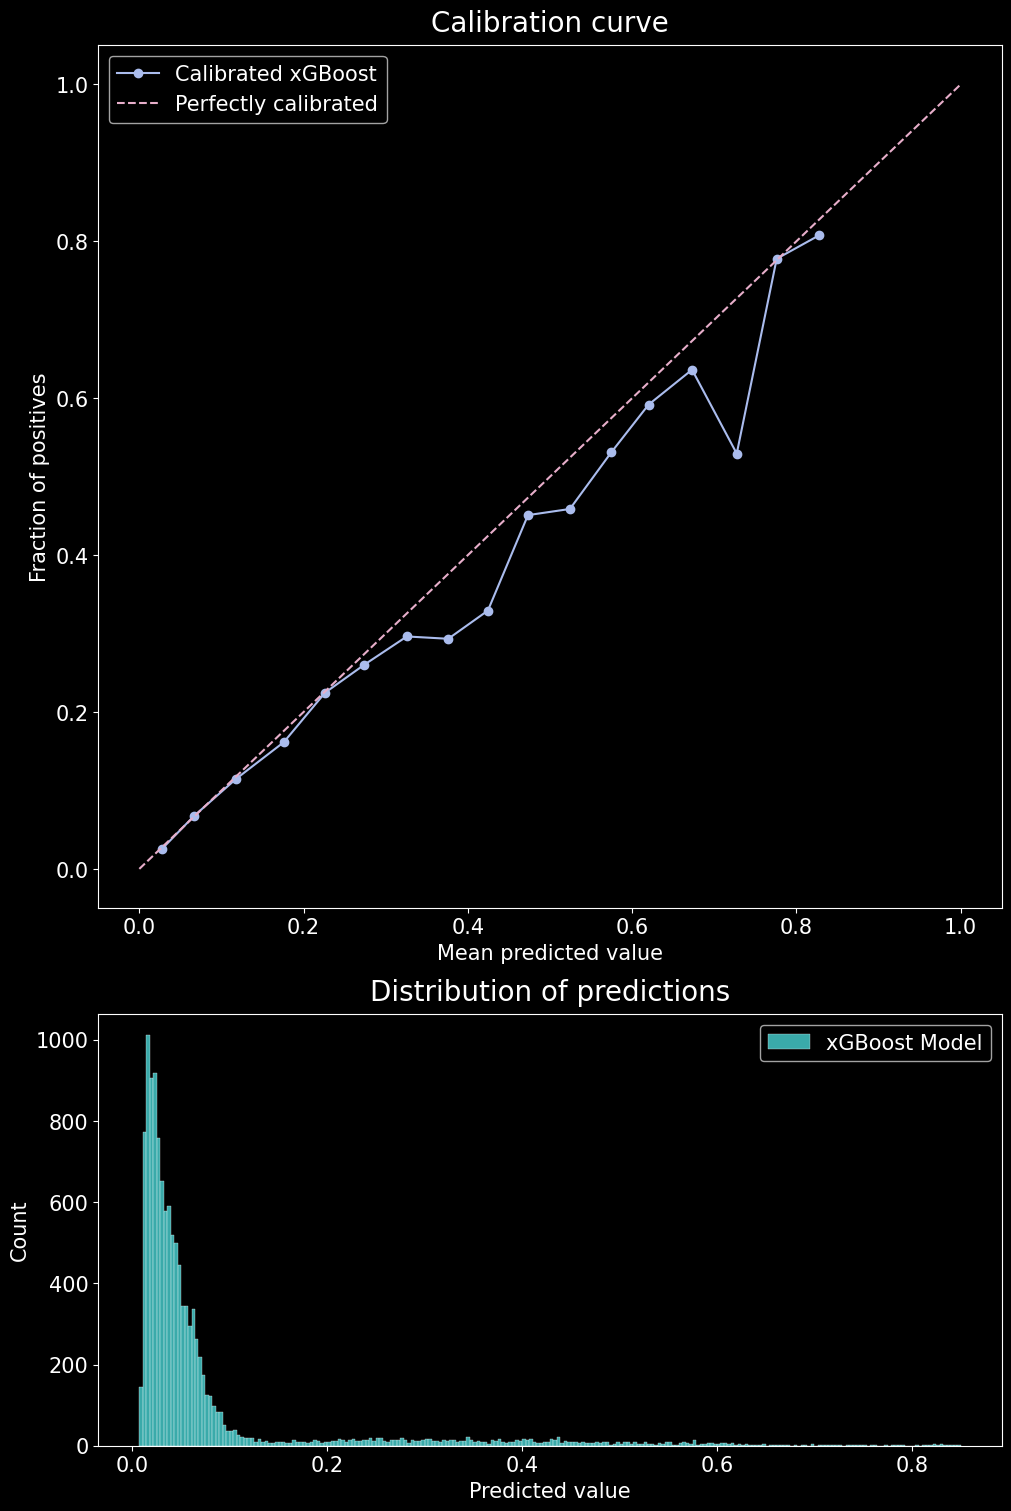

In [55]:
fraction_of_positives_lgbm, mean_predicted_value_lgbm = calibration_curve(y_test, y_pred_lgbm_calibrated, n_bins=20)
plt.style.use('dark_background')
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_lgbm, fraction_of_positives_lgbm, "-o", color='#aabced', label='Calibrated xGBoost')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.histplot(y_pred_lgbm_calibrated, color='#4fe4e4', label='xGBoost Model', kde=False, ax=ax2,bins='fd')
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10)
plt.show()

### Calculate different metrics for testing the model

In [56]:
from metrics import expected_calibration_error
print('Brier Error, xgboost (%):', brier_score_loss(y_test, y_pred_lgbm_calibrated, pos_label=y_test.max())*100,'%')
print('ROC AUC, xgboost:', roc_auc_score(y_test, y_pred_lgbm_calibrated))
print('Pseudo R-squared, xgboost:', mcfadden_r2(y_test, y_pred_lgbm_calibrated))
print("Exp. Calibration Error (%): ", expected_calibration_error(y_test,y_pred_lgbm_calibrated)*100,'%')

Brier Error, xgboost (%): 5.572146272938923 %
ROC AUC, xgboost: 0.8115327291432892
Pseudo R-squared, xgboost: 0.21085925112048143
Exp. Calibration Error (%):  0.4368318376379459 %


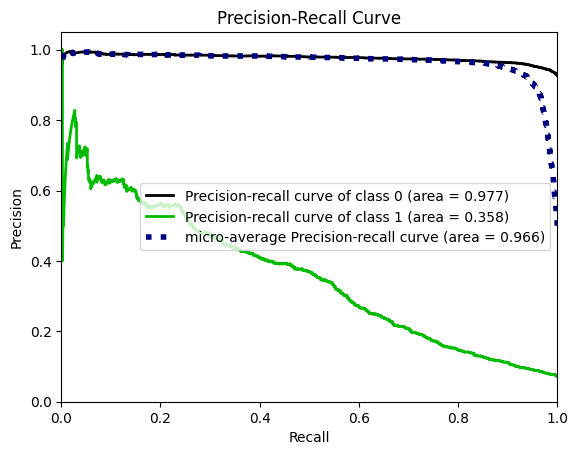

In [57]:
plt.style.use('default')
from scikitplot.metrics import plot_precision_recall,plot_cumulative_gain,plot_ks_statistic
y_probas = searchcv.best_estimator_.predict_proba(X_test)
plot_precision_recall(y_test,y_probas)
plt.show()

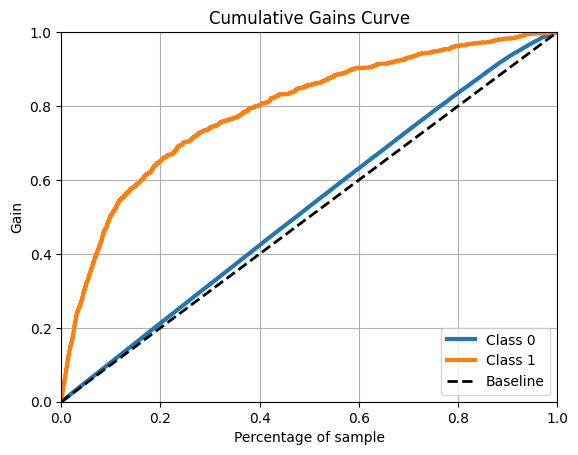

In [58]:
plot_cumulative_gain(y_test,y_probas)
plt.show()

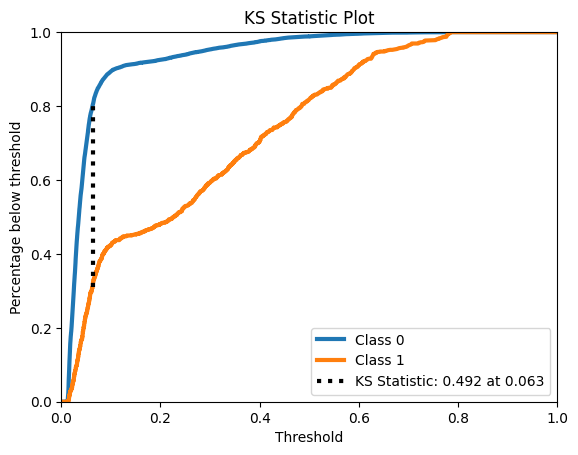

In [59]:
plot_ks_statistic(y_test,y_probas)
plt.show()

## Visualising Expected Goal on the Football Pitch

In [60]:
from mplsoccer.pitch import Pitch,VerticalPitch
xg_df=train_df.copy()
xg_df['isGoal']=goal
xg_df['xG']=searchcv.best_estimator_.predict_proba(train_df)[:, 1]

In [61]:
np.sum(xg_df['xG']),np.sum(goal)

(4650.1885, 4380)

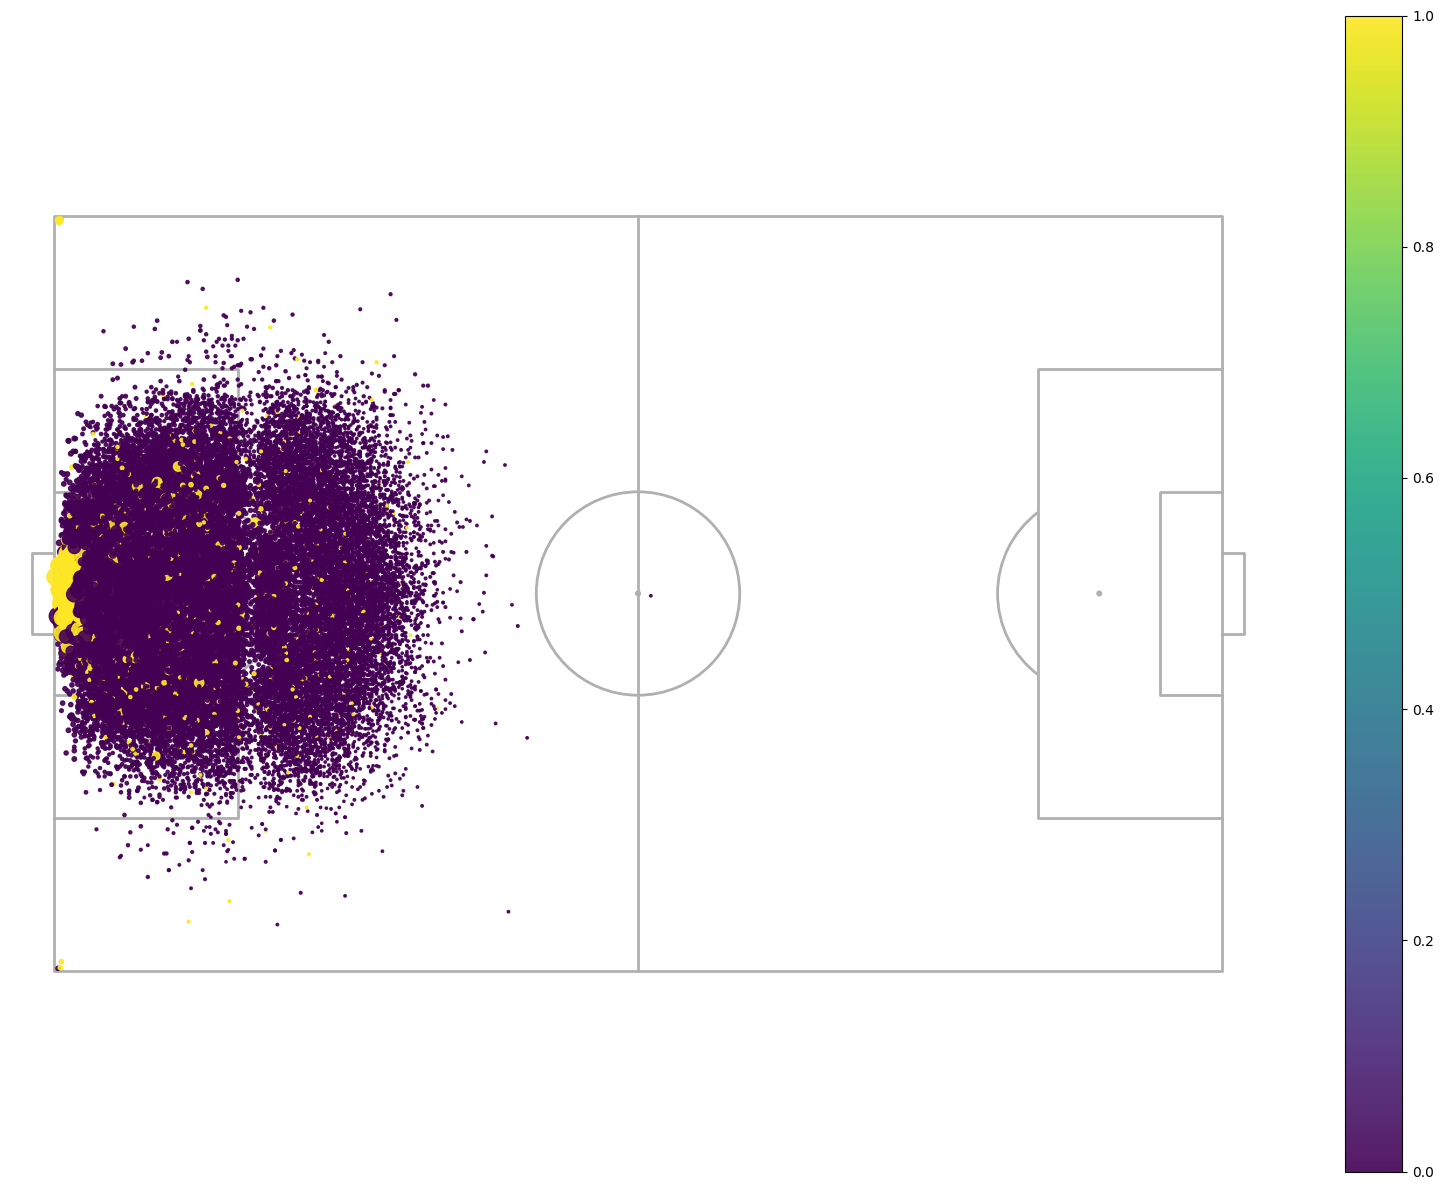

In [62]:
pitch = Pitch(pitch_type='uefa',goal_type='box')
plt.style.use('default')
fig, ax = pitch.draw(figsize=(16,12))
a=ax.scatter(xg_df.x,xg_df.y,s=xg_df['xG']*200,alpha=.9,c=goal)
plt.colorbar(a)
plt.show()

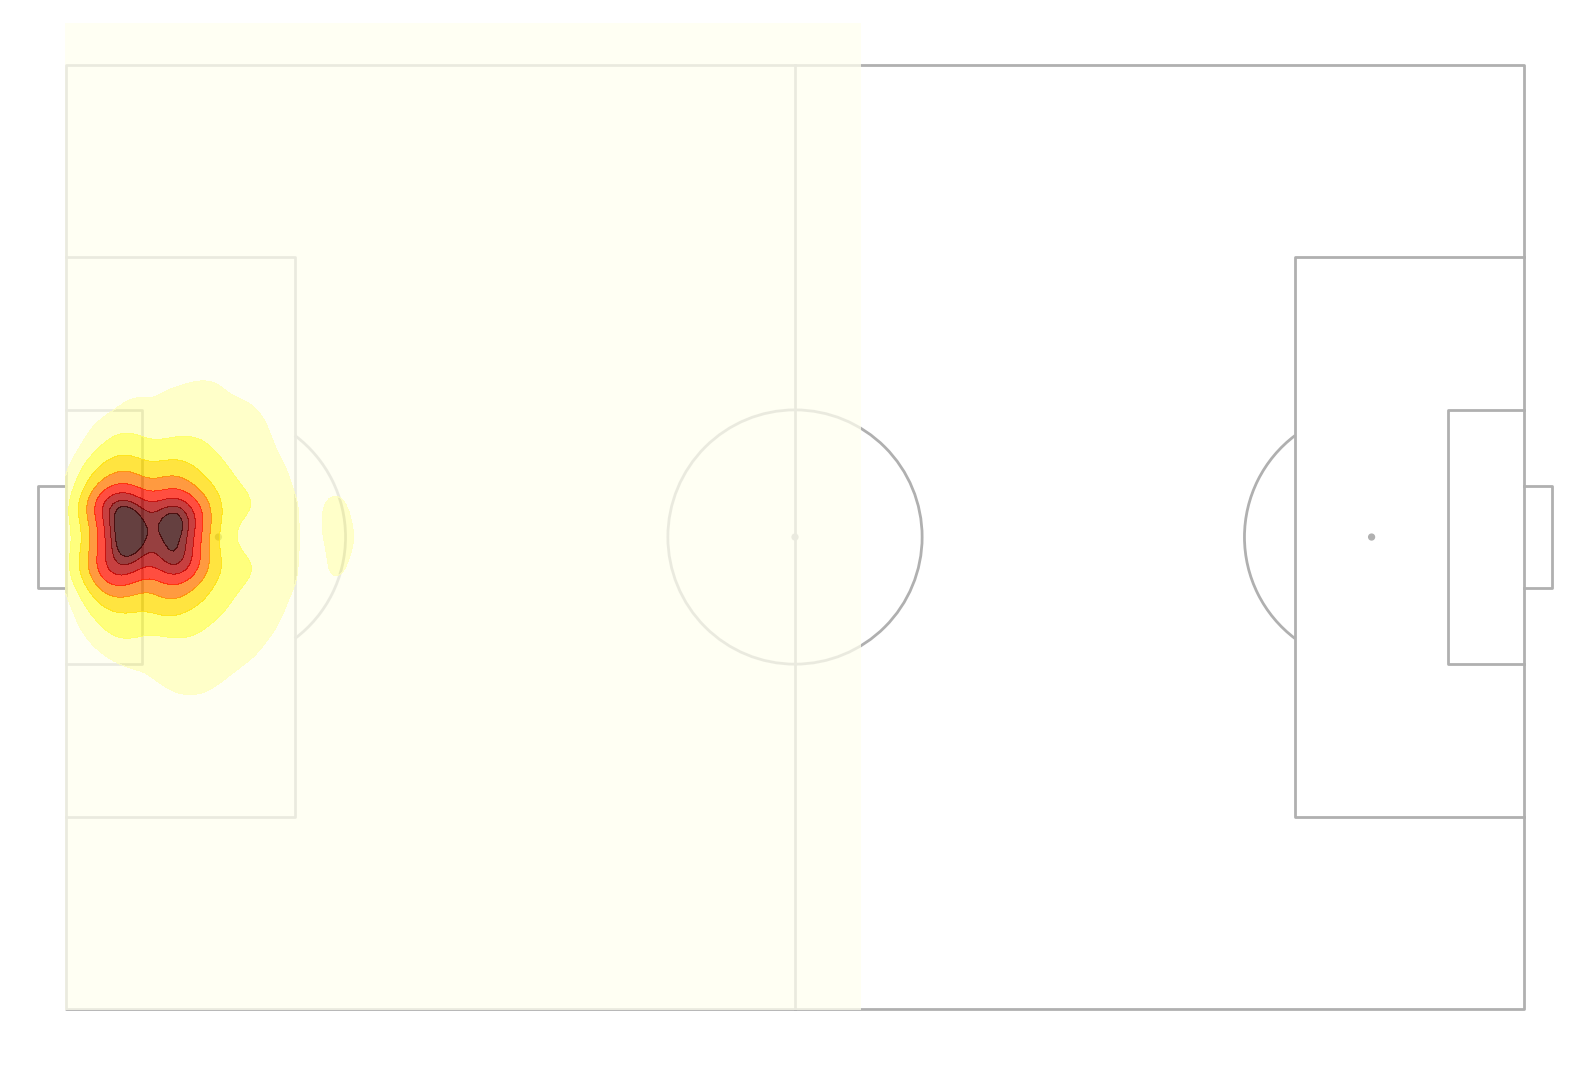

In [67]:
pitch = Pitch(pitch_type='uefa',goal_type='box')
plt.style.use('default')
fig, ax = pitch.draw(figsize=(16,12))
norm=plt.Normalize(xg_df['xG'].min(),xg_df['xG'].max())
sns.kdeplot(x=xg_df.x,y=xg_df.y,cmap='hot_r',
                alpha=0.75,fill=True,weights=xg_df['xG'],
                thresh=0.0,clip=(0,105,0,68),levels=10,
                #gridsize=250,#cbar=True,
                bw_adjust=1,common_norm=norm
                )
plt.show()

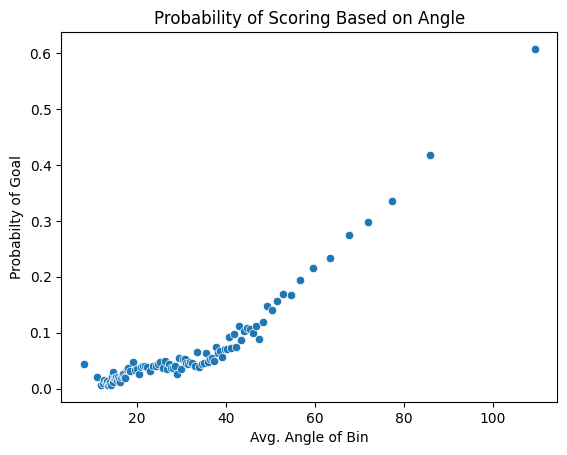

In [68]:
xg_df['angle_deg']=xg_df['angle_rad']*180/np.pi
xg_df['Angle_Bins'] = pd.qcut(xg_df['angle_deg'],q=100)
angle_prob = xg_df.groupby('Angle_Bins',as_index=False)['isGoal'].mean()['isGoal']
angle_mean = xg_df.groupby('Angle_Bins',as_index=False)['angle_deg'].mean()['angle_deg']
angle_trend = sns.scatterplot(x=angle_mean,y=angle_prob)
angle_trend.set(xlabel="Avg. Angle of Bin",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Angle")
# plt.scatter(xg_df['angle_rad']*180/np.pi,xg_df['xG'],s=2)

plt.show()

In [69]:
#SAVE MODEL
import joblib
joblib.dump(searchcv, 'E:\\Athan\\football data\\xG_Model\\Model\\xgboost_setpiece_model.joblib') 

['E:\\Athan\\football data\\xG_Model\\Model\\xgboost_setpiece_model.joblib']